In [2]:
import numpy as np
import matplotlib
from scipy.interpolate import interpolate as II
from pylab import *
from astropy.convolution import convolve
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

import astropy.units as u
from astropy.constants import G, h, c, k_B


ion()

%matplotlib inline

_ = np.array

# Optics

In [3]:
# Wl(mi)  2Wndos   Col #1   Mirror   Col #2   Col #3   Col #4   Col #5   Col #6
tbl = '''0.850   0.9481   0.9514   0.9531   0.9684   0.9276   0.9556   0.9250   0.9706
0.975   0.9681   0.9714   0.9731   0.9884   0.9476   0.9756   0.9750   0.9906
0.985   0.9724   0.9716   0.9737   0.9896   0.9539   0.9814   0.9765   0.9909
1.000   0.9787   0.9720   0.9744   0.9895   0.9644   0.9882   0.9772   0.9894
1.100   0.9530   0.9730   0.9772   0.9805   0.9937   0.9865   0.9809   0.9869
1.200   0.9303   0.9774   0.9822   0.9903   0.9922   0.9928   0.9769   0.9927
1.300   0.9461   0.9733   0.9848   0.9856   0.9827   0.9889   0.9789   0.9861
1.400   0.9635   0.9725   0.9862   0.9798   0.9766   0.9836   0.9828   0.9816
1.500   0.9628   0.9783   0.9869   0.9806   0.9762   0.9832   0.9861   0.9820
1.600   0.9518   0.9838   0.9885   0.9835   0.9795   0.9850   0.9874   0.9842
1.700   0.9452   0.9840   0.9901   0.9840   0.9850   0.9852   0.9861   0.9834
1.800   0.9465   0.9805   0.9925   0.9799   0.9900   0.9849   0.9839   0.9811
1.900   0.9555   0.9765   0.9931   0.9777   0.9935   0.9846   0.9823   0.9810
2.000   0.9671   0.9755   0.9938   0.9779   0.9948   0.9854   0.9826   0.9812
2.100   0.9797   0.9770   0.9946   0.9801   0.9938   0.9873   0.9846   0.9828
2.200   0.9829   0.9789   0.9952   0.9821   0.9907   0.9884   0.9856   0.9842
2.300   0.9813   0.9795   0.9956   0.9829   0.9854   0.9879   0.9849   0.9848
2.400   0.9683   0.9774   0.9960   0.9811   0.9794   0.9829   0.9816   0.9820'''

# Wl(mi) Cam #1   Cam #2 Cam #3  Cam #4 Cam #5 Cam #6 Cam #7 
tbl2 = '''0.850 0.9463  0.9544 0.9572  0.9583 0.9644 0.9249 0.9563
0.975   0.9663  0.9744 0.9772  0.9783 0.9844 0.9449 0.9763        
0.985   0.9669  0.9828 0.9827  0.9830 0.9852 0.9568 0.9822 
1.000   0.9673  0.9874 0.9855  0.9878 0.9859 0.9729 0.9870 
1.100   0.9706  0.9855 0.9909  0.9907 0.9802 0.9777 0.9908 
1.200   0.9771  0.9848 0.9848  0.9887 0.9863 0.9712 0.9851 
1.300   0.9722  0.9832 0.9842  0.9826 0.9886 0.9766 0.9850 
1.400   0.9720  0.9837 0.9903  0.9819 0.9901 0.9820 0.9904 
1.500   0.9776  0.9865 0.9949  0.9852 0.9917 0.9856 0.9936 
1.600   0.9814  0.9869 0.9940  0.9888 0.9915 0.9856 0.9916 
1.700   0.9804  0.9852 0.9891  0.9889 0.9910 0.9837 0.9866 
1.800   0.9776  0.9825 0.9853  0.9885 0.9901 0.9813 0.9827 
1.900   0.9747  0.9826 0.9843  0.9888 0.9894 0.9805 0.9823 
2.000   0.9741  0.9843 0.9856  0.9897 0.9906 0.9809 0.9831 
2.100   0.9762  0.9880 0.9884  0.9908 0.9914 0.9847 0.9864 
2.200   0.9790  0.9917 0.9898  0.9909 0.9901 0.9882 0.9868 
2.300   0.9783  0.9934 0.9887  0.9884 0.9872 0.9889 0.9861 
2.400   0.9749  0.9913 0.9837  0.9832 0.9821 0.9864 0.9792'''

In [4]:
opt1 = np.fromstring(tbl, sep=' \n')
opt2 = np.fromstring(tbl2, sep=' \n')

In [5]:
opt1 = opt1.reshape((18, 9))
opt2 = opt2.reshape((18, 8))

In [6]:
l, windows2, col1, mirror, col2, col3, col4, col5, col6 = opt1.T  # ABN: originally was opt2? and without col6

ADC = windows2
corr = windows2 * col1
col = col1*col2*col3 # Check with NPK that col4-6 are unused

# Dichroics: Assuming optical transmission suffers 2% loss, IR transmission suffers 5% loss, reflections negligible
# loss based on Asahi dichroics for PFS

#dichroic = 0*mirror + 0.98 # 2% hit from first I band dichroic in all channels
#dichroic[l > 1.124] *= 0.95 # add 1 transmission hit for J, H, K...
#dichroic[l > 1.921] *= 0.95 # ...and 1 more transmission for K

In [7]:
l, c1, c2, c3, c4, c5, c6, c7 = opt2.T
camera = c1*c2*c3*c4*c5*c6*c7 # * c5 # Multiply by another for filter
camera *= 0.95 # ABN assuming 95% filters per MOSFIRE (slightly worse in Y and K, slightly better in H)

In [8]:
tree = np.ones_like(l)

T = 0.98
R = 0.995
tree[l <= 1.124] = T**2 * R**2
tree[(l >= 1.124) & (l < 1.352)] = T**2 * R * T**2
tree[(l >= 1.352) & (l < 1.807)] = T**2 * T**2 * R
tree[(l >= 1.807)] = T**2 * T**2 * T**2

dichroic = tree

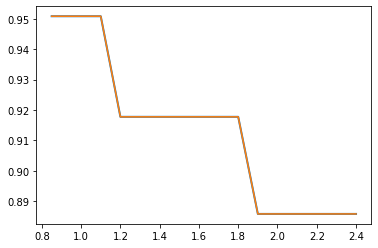

In [9]:
plot(l, tree, lw=2)
plot(l, dichroic)

# Detector

In [10]:
QE = lambda x: 0.85*np.ones_like(x)

# Telescope

In [11]:
#tel = lambda x: 0.95**3
# ABN
# For primary, taking Subaru primary ~1 year after recoating:
# https://www.naoj.org/Observing/Telescope/Parameters/Reflectivity/subaru_m1_r_20181107.txt
# assuming reflectance is constant at > 1.65 micron. This looks close to data provided by P. Povilas
# out to ~1 micron, if we take measurements half-way between his 'clean' and 'dirty' data.
# If we're going to use an Ag-coated M3 then this can be updated.
#tel = lambda x: np.interp(x, np.array([0.88, 0.94, 1.0, 1.1, 1.6, 2.4]), np.array([0.85, 0.88, 0.90, 0.93, 0.95, 0.95])**3) 
tel = II.interp1d(np.array([0.75, 0.85, 0.88, 0.94, 1.0, 1.1, 1.6, 2.4]), np.array([0.84, 0.83, 0.85, 0.88, 0.90, 0.93, 0.95, 0.95])**3, bounds_error=False, fill_value=0, kind='linear')

# Stops - Pupil and Lyot

In [12]:
def stops(lam):
    
    res = np.ones_like(lam)
    
    res[lam < 1.921] = .95
    res[lam >= 1.921] = .85

    return res

# Margin

In [13]:
margin = lambda x: 0.9*np.ones_like(x)
# ABN Changed per NPK suggestion

# Optics + Detector + Tel

In [14]:
thpt_optdet = II.interp1d(l, ADC*corr*col*camera*dichroic * QE(l) * tel(l) * margin(l) * stops(l), bounds_error=False, fill_value=0)


# VPHG

In [15]:
print("ADC:        ",II.interp1d(l, ADC)([1., 1.6, 2.2]))
print("Corrector:  ",II.interp1d(l, corr)([1., 1.6, 2.2]))
print("Collimator: ",II.interp1d(l, col)([1., 1.6, 2.2]))
print("Camera:     ",II.interp1d(l, camera)([1., 1.6, 2.2]))

ADC:         [0.9787 0.9518 0.9829]
Corrector:   [0.9512964  0.93638084 0.96216081]
Collimator:  [0.92755413 0.94773217 0.95243688]
Camera:      [0.83622238 0.8763298  0.87340754]


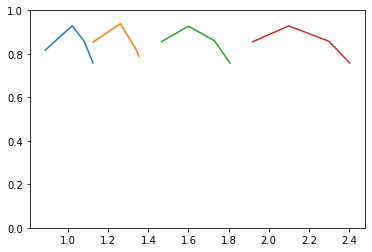

In [16]:
ly = _([0.886, 1.02, 1.08, 1.124])
ty = _([.86, .98, .9, .8])
fy = np.poly1d(np.polyfit(ly,ty,2)) * .95

lj = _([1.124, 1.260, 1.340, 1.352]) 
tj = _([.9, .98, .9, .8])
fj = np.poly1d(np.polyfit(lj,tj,2)) *.95

lh = _([1.466, 1.6, 1.73, 1.807])
th = _([.9, .98, .9, .8])
fh = np.poly1d(np.polyfit(lh,th,2)) * .95

lk = _([1.921, 2.1, 2.3, 2.404])
tk = _([.9, .98, .9, .8]) 
fk = np.poly1d(np.polyfit(lk, tk, 2)) * .95

#plot(ly,ty)
plot(ly, fy(ly))
plot(lj, fj(lj))
plot(lh, fh(lh))
plot(lk, fk(lk))

ylim(0,1)
show()

# Atmosphere

In [17]:
#latm1.min()

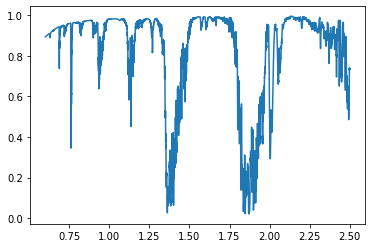

In [18]:
#try:
#    dat1
#except:

ii = np.loadtxt("../MIRMOS-filters/transmission.dat.txt")
latm, tatm = ii.T
latm /= 1000



box_kernel = Box1DKernel(11)
plot(latm, convolve(tatm, box_kernel, boundary='extend'));

In [19]:
tpt_atm = II.interp1d(latm, convolve(tatm, box_kernel, boundary='extend'))

In [20]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc("font", **font)

In [21]:
margin(l)

array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9])

In [62]:
np.max(lk)

2.404

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


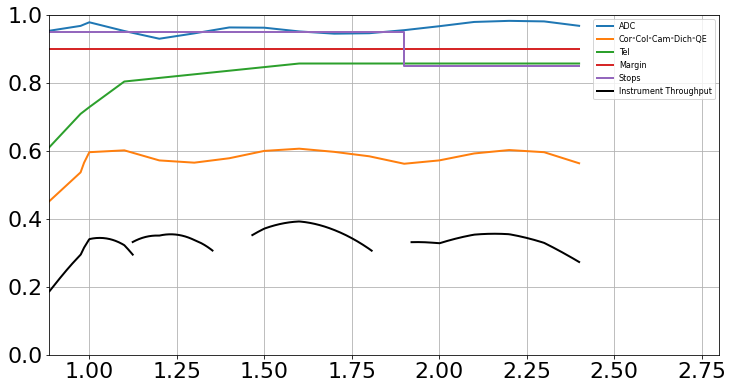

In [69]:

figure(figsize=(12,10/1.6))
plot(l, ADC, lw=2)
plot(l, corr*col*camera*dichroic*QE(l), lw=2)
plot(l, tel(l), lw=2)



plot(l, margin(l), lw=2)
step(l,stops(l), lw=2)

ly = np.linspace(np.min(ly), np.max(ly), 150)
lj = np.linspace(np.min(lj), np.max(lj), 150)
lh = np.linspace(np.min(lh), np.max(lh), 150)
lk = np.linspace(np.min(lk), 2.4, 150)

for s in ["y", "j", "h", "k"]:
    ll, band_thpt = eval("l%s, thpt_optdet(l%s) * f%s(l%s)" % (s,s,s,s))
    plot(ll, band_thpt, color='black', lw=2)


xlim(0.886,2.8)
ylim(0,1)

grid(True)
legend(["ADC", "CorˣColˣCamˣDichˣQE", "Tel", "Margin", "Stops", "Instrument Throughput"], loc="upper right", prop={'size': 8})

#*corr*col*camera*dichroic * QE(l) * tel(l) * margin(l) * stops(l))

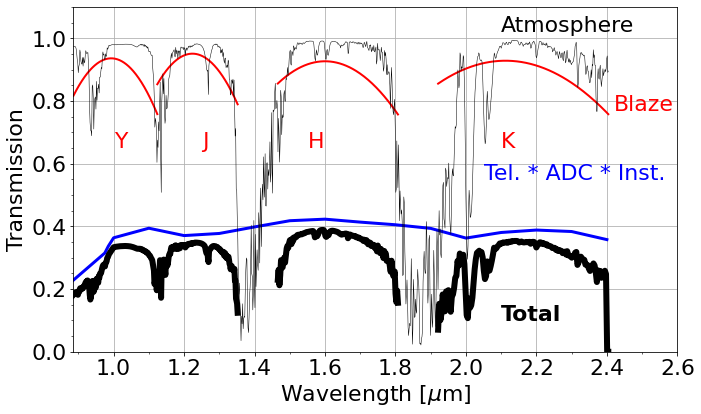

In [58]:
def makeplot(savefig=True, yrange=None, **args):
    global ly, lj, lh, lk
    f = figure(**args)

    plot(l,thpt_optdet(l), lw=3, color='blue')
    xlabel(r"Wavelength [$\mu$m]")
    ylabel("Transmission")

    ly = np.linspace(np.min(ly), np.max(ly), 150)
    lj = np.linspace(np.min(lj), np.max(lj), 150)
    lh = np.linspace(np.min(lh), np.max(lh), 150)
    lk = np.linspace(np.min(lk), np.max(lk), 150)


    for s in ["y", "j", "h", "k"]:
        band_thpt = eval("thpt_optdet(l%s) * tpt_atm(l%s) * f%s(l%s)" % (s,s,s,s))
        band_thpt_noatm = eval("thpt_optdet(l%s) * f%s(l%s)" % (s,s,s))

        eval("plot(l%s, band_thpt, lw=6, color='black')" % s)

        eval("plot(l%s, f%s(l%s), lw=2, color='red')" % (s,s,s))
        #eval("plot(l, f%s(l), color='black', lw=.25)" % s)
        # Save the throughput including everything but atmosphere
        thpt_output = eval("thpt_optdet(l%s) * f%s(l%s)" % (s,s,s))
        np.savetxt('MIRMOS-thpt-%s-codr.dat' % s, np.column_stack([eval('l%s'%s), thpt_output]),
                   fmt=['%0.3f', '%0.3f'], 
                   header='ADC x corrector x collimator x camera x dichroics x VPHG x detector x stops x telescope x margin (no atmosphere)')
        np.savetxt('MIRMOS-thpt-nomargin-%s-codr.dat' % s, np.column_stack([eval('l%s'%s), thpt_output / margin(1)]),
                   fmt=['%0.3f', '%0.3f'], 
                   header='ADC x corrector x collimator x camera x dichroics x VPHG x detector x stops x telescope x margin (no atmosphere)')

    lnew = np.linspace(np.min(ly), np.max(lk), 1000)
    plot(lnew, tpt_atm(lnew), color='black', lw=.5)

    if yrange is None:
        text(2.1, 1.02, "Atmosphere")
        text(2.42, 0.77, "Blaze", color="red")
        text(2.05, 0.55, "Tel. * ADC * Inst.", color='Blue')

        yp = .65
        text(1.00, yp, "Y", color='red')
        text(1.25, yp, "J", color='red')
        text(1.55, yp, "H", color='red')
        text(2.10, yp, "K", color='red')

    font = {'family' : 'normal',
            'weight' : 'bold'}
    text(2.1, 0.1, "Total", color='black', fontdict=font)

    from matplotlib.ticker import MultipleLocator
    gca().yaxis.set_minor_locator(MultipleLocator(0.05))
    gca().xaxis.set_minor_locator(MultipleLocator(0.1))
    if yrange is None: ylim(0,1.1)
    else: ylim(yrange)
    xlim(0.886,2.6)
    grid(True)

    tight_layout()
    if savefig: f.savefig("MIRMOS-thpt.pdf")

makeplot(figsize=(10,10/1.61))

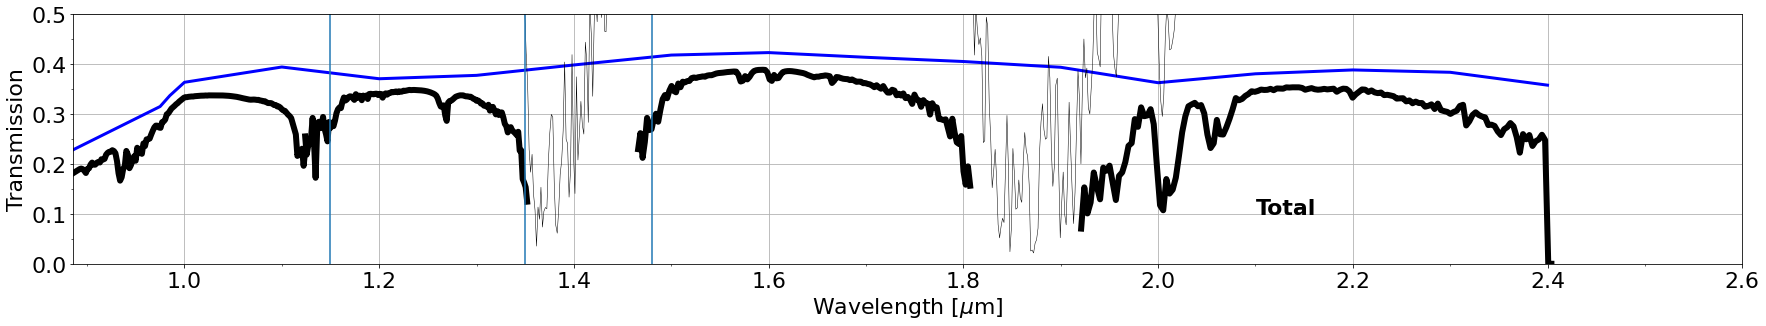

In [24]:
# Blow up the scale
makeplot(savefig=False, yrange=[0,0.5],figsize=(25,5))
axvline(1.48)
axvline(1.15)
axvline(1.35)


# Ultra High Precision Mode

In [27]:
s=u.second
texp = "texp"
Res = "Res"
airmass = "airmass"
Atel = "Atel"
Dtel = "Dtel"
res_size_pix = "res_size_pix"
rn_pix = "rn_pix"
Res_Binned = "Res_Binned"

observation = {...}

In [37]:
def subpixel_noise(npix):
    
    return 0.001 / np.sqrt(npix) 

In [38]:
def young_scintillation_noise(obs, verbose=False):
    """ Returns the fractional δσ/f """

    D = obs[Dtel]
    X = obs[airmass]
    h0 = 8000*u.m
    h_lco = 2000*u.m
    
    
    Dravins_σ_f = np.array(0.09) * np.power(D/u.cm, -2/3) * np.power(X, 1.75) * np.exp(-h_lco/h0)/np.sqrt(2*obs["et"]/u.s)
    
    # Kornilov et al. :
    Kornilov_σ_f = 0.0030 * (D/u.m)**(-2/3) * X**1.75 * np.exp(-h_lco/h0)/np.sqrt(obs["et"]/u.s)
    
    # Jason's Mystery paper:
    h0 = 5500*u.m

    m_s_f = 1.6 * (D/u.m)**(-2/3) * X**1.75 * (8000/5500)**(-7/12) / np.sqrt(obs["et"]/u.s)
    
    # Osborn Variance
    Osborn_var = 10 * 1e-6 * (D/u.m)**(-4/3) / (obs["et"]/u.s) * X**(-3) * np.exp(-2*h_lco/h0)
    
    if verbose: print(Dravins_σ_f.cgs, Kornilov_σ_f.cgs, m_s_f.cgs, np.sqrt(Osborn_var.cgs))
    
    return Dravins_σ_f.cgs * 1.3

In [39]:
def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

In [40]:
def snr_per_exp(targ_mag, obs, thpt=0.35, λeff=15000*u.Angstrom, well_sig=60000):
    
    targ_fd = targ_mag.to(u.erg/u.s/u.Angstrom/u.cm**2, u.spectral_density(λeff))
    
    obs["flux_density"] = targ_fd
    
    hc=h*c
    epp = hc/λeff
    δλ = λeff/obs[Res]
    Atel = np.pi * (obs[Dtel]/2)**2
    targ_eps  = (thpt * targ_fd * δλ * Atel / epp)
    tar_eps_pix = targ_eps / obs[res_size_pix]
    
    tar_eps_pix = (60000.0/tar_eps_pix).cgs
    
    et = (clamp(20*u.s, tar_eps_pix, 240*u.s)).cgs
    
    obs["Nγ/s"] = targ_eps.cgs
    obs["Nγ_res"] = (targ_eps*et).cgs
    obs["et"] = et
    eff = (et/(et+obs["readout_overhead"])).cgs
    obs["observing_efficiency"] = eff
    obs["Nγ_pix"] = obs["Nγ_res"] / obs[res_size_pix] * eff
    
    f = young_scintillation_noise(obs)/3

    obs["scintillation_f_per_exp"] = f

    # binning factor
    bf = obs[Res]/obs["Res_Binned"]
    obs["Nγ_res"] = obs["Nγ_res"] * bf
    
    
    rn = np.sqrt(bf*obs["res_size_pix"])*obs[rn_pix]
    #var_res = rn**2 + bf*obs["Nγ_pix"] + (obs["Nγ_res"] * f)**2
    obs["rn_res"] = rn
    obs["shotnoise_res"] = np.sqrt(obs["Nγ_res"])
    obs["scintnoise_res"] = obs["Nγ_res"] * f
    
    var_res = obs["rn_res"]**2 + obs["shotnoise_res"]**2 + obs["scintnoise_res"]**2
    snr_res = obs["Nγ_res"] / np.sqrt(var_res)
    
    
    obs["snr_res"] = snr_res.cgs

    obs["Σnoise_res"] = np.sqrt(var_res)
    obs["DQE_res"] = snr_res/np.sqrt(obs["Nγ_res"])
    
    return obs

def snr_per_transit(targ_mag, total_time, obs):
    
    single_exp = snr_per_exp(targ_mag, obs)
    
    Nexp_needed = np.ceil((total_time / single_exp["et"]).cgs)
    
    obs["Nexp_needed"] = Nexp_needed
    obs["snr_res_sum"] = obs["snr_res"] * np.sqrt(Nexp_needed)
    obs["unc_res_sum"] = 1/obs["snr_res_sum"]
    
    # Noise Propagation
    def f(x): obs[x+"_sum"] = obs[x] / np.sqrt(Nexp_needed)
    f("rn_res") ; f("shotnoise_res") ; f("Σnoise_res") ; f("scintnoise_res")
    
    
    obs["Nγ_sum"] = obs["Nγ_res"] * Nexp_needed
    obs["DQE_sum"] = obs["snr_res_sum"] / np.sqrt(obs["Nγ_sum"])
    
    return obs

In [41]:
obs = {Res: 4000, Res_Binned: 100, Dtel: 1*u.m,
      rn_pix: 5, res_size_pix: 3*10, airmass: 1.0,
      "readout_overhead": 5*u.s}


r = snr_per_transit(11*u.ABmag, 30*u.min, obs)

print()
print(r["unc_res_sum"]/1e-6)


298.63610776764506


In [53]:
mags = np.arange(4,14,0.1)
rs = np.zeros_like(mags)
ets = np.zeros_like(mags)
rns = np.zeros_like(mags)
sns = np.zeros_like(mags)
scns = np.zeros_like(mags)
gnn = np.zeros_like(mags)
effs = np.zeros_like(mags)
ngs = np.zeros_like(mags)
gnn[:] = 33

obs = {Res: 4000., Res_Binned: 100., Dtel: 6.5*u.m,
      rn_pix: 15., res_size_pix: 3*10., airmass: 1.2,"readout_overhead": 5*u.s}

for ix,m in enumerate(mags):
    r = snr_per_transit(m*u.ABmag, 30*u.min, obs)
    totn = r["Σnoise_res_sum"]
    shotn = r["shotnoise_res_sum"]
    rn = r["rn_res_sum"]
    scn = r["scintnoise_res_sum"]
    eff = r["observing_efficiency"]
    
    rs[ix] = r["unc_res_sum"]/1e-6
    rns[ix] = rn/totn * rs[ix]
    sns[ix] = shotn/totn * rs[ix]
    scns[ix] = scn/totn * rs[ix]
    effs[ix] = eff
    ets[ix] = r["et"].value
    ngs[ix] = r["Nγ_sum"]

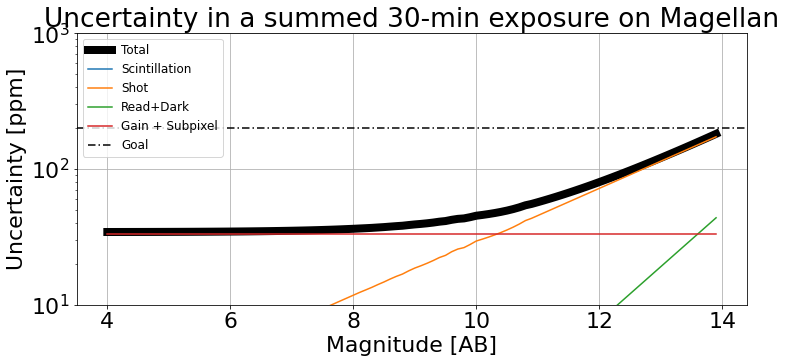

In [54]:
figure(figsize=(12,5))
semilogy(mags,np.sqrt(rs**2+gnn**2),lw=8,color="black")
plot(mags,scns)
plot(mags,sns)
plot(mags,rns)
plot(mags, gnn)
axhline(200, color="black", dashes= (5, 2, 1, 2) )

legend(["Total", "Scintillation", "Shot", "Read+Dark", "Gain + Subpixel", "Goal"], prop={'size':12})

xlabel("Magnitude [AB]")
ylabel("Uncertainty [ppm]")
title("Uncertainty in a summed 30-min exposure on Magellan")

grid(True)
ylim(10,1000)

savefig("uncert-as-mag.pdf")